# Memory task initial data exploration
## Matt Oberhardt



### Imports & API calls:

In [1]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
%matplotlib inline  
# from pandas import DataFrame, Series


In [2]:


# log in
def login_synapse(username, password):
    syn = synapseclient.Synapse()
    syn.login(username, password) # need to change this, security.
    return syn


# get the memory table up and running:
def load_memory_table_from_synapse(syn):
    memorysyn = syn.tableQuery("select * from %s" % 'syn5511434')
    memory = memorysyn.asDataFrame()

    # rename columns:
    memory.columns = [u'recordId', u'healthCode', u'createdOn',
        u'appVersion', u'phoneInfo', u'game_score',
        u'game_numGames', u'game_numFails', u'game_startDate',
        u'game_endDate', u'game_records', u'medTimepoint']

    # remove rows with null in the game_records column:
    memory = memory.dropna(subset=["game_records"])

    # Convert 'game_records' into a text key that matches filePaths:
    for rec in memory.game_records:
        assert (len(str(rec)) == 9), "records will not be parsed right since they are not the correct length - check %s" % rec
    memory['game_records_txt'] = memory.game_records.apply(lambda r: str(r)[:7])

    # finish:
    return memory, memorysyn


# get the demographics table up and running:
def load_demographics_table_from_synapse(syn):
    demosyn = syn.tableQuery("select * from %s" % 'syn5511429')
    demographics = demosyn.asDataFrame()

    # rename columns:
    demographics.columns = ([u'recordId', u'healthCode', u'createdOn', u'appVersion', u'phoneInfo',
       u'age', u'isCaretaker', u'brainStim', u'diagYear',
       u'education', u'employment', u'gender', u'healthHistory',
       u'healthcareProvider', u'homeUsage', u'lastSmoked', u'maritalStatus',
       u'medicalUsage', u'medicalUsageYesterday', u'medicationStartYear',
       u'onsetYear', u'packsPerDay', u'pastParticipation', u'phoneUsage',
       u'professionalDiagnosis', u'race', u'smartphone', u'smoked',
       u'surgery', u'videoUsage', u'yearsSmoking'])

    # finish:
    return demographics, demosyn


# get the json files (slow, only load from scratch once):
def load_memory_game_results_from_synapse(syn, memorysyn, fromScratch = False):
    if fromScratch:
        filePaths = syn.downloadTableColumns(memorysyn, u'MemoryGameResults.json.MemoryGameGameRecords')
        pickle.dump( filePaths, open( "filePaths_for_memory.p", "wb" ) )
    else:
        filePaths = pickle.load( open( "filePaths_for_memory.p", "rb" ) )
    return filePaths


# load in the json data for a memory test:
def load_memory_results_json(filePaths, game_record_txt):
#    with open(filePaths[u'5732386']) as data_file:
    with open(filePaths[game_record_txt]) as data_file:
        game_record = json.load(data_file)
    return game_record




### Load up the memory & demographic data:

In [3]:
## load in the data:

# logs in with credentials from os environment)
syn = login_synapse(os.environ['SYNAPSE_USER'], os.environ['SYNAPSE_PASS']) 

# load up tables:
memory, memorysyn = load_memory_table_from_synapse(syn)
filePaths = load_memory_game_results_from_synapse(syn, memorysyn)
demographics, demosyn = load_demographics_table_from_synapse(syn)
data = pd.merge(left=memory, right=demographics, how='inner', left_on='healthCode', right_on='healthCode')

# data is the main table, with memory and demographic data

Welcome, Matthew Oberhardt!


### Visualize the memory data:

#### Columns:

In [34]:
# columns:
for col in data.columns:
    print col

recordId_x
healthCode
createdOn_x
appVersion_x
phoneInfo_x
game_score
game_numGames
game_numFails
game_startDate
game_endDate
game_records
medTimepoint
game_records_txt
recordId_y
createdOn_y
appVersion_y
phoneInfo_y
age
isCaretaker
brainStim
diagYear
education
employment
gender
healthHistory
healthcareProvider
homeUsage
lastSmoked
maritalStatus
medicalUsage
medicalUsageYesterday
medicationStartYear
onsetYear
packsPerDay
pastParticipation
phoneUsage
professionalDiagnosis
race
smartphone
smoked
surgery
videoUsage
yearsSmoking


In [35]:
# summary stats:
data.describe()

,createdOn_x,game_score,game_numGames,game_numFails,game_startDate,game_endDate,game_records,createdOn_y,age,diagYear,lastSmoked,medicationStartYear,onsetYear,packsPerDay,yearsSmoking
count,7.981000e+03,7981.000000,7981.000000,7981.000000,7.981000e+03,7.981000e+03,7981.000000,7.981000e+03,7966.000000,6231.000000,2355.000000,6819.000000,6544.000000,2087.000000,2426.000000
mean,1.434635e+12,261.678988,4.996617,1.326651,1.434635e+12,1.434635e+12,5644469.313119,1.429334e+12,61.540673,2010.660889,1983.901911,1697.334507,2008.960880,1.176809,11.690025
std,3.626476e+09,59.984544,0.069827,0.581182,3.626477e+09,3.626475e+09,164683.766810,4.026537e+09,13.772669,3.699084,15.217572,729.861338,4.690024,0.389063,9.427551
min,1.429653e+12,0.000000,3.000000,0.000000,1.429653e+12,1.429653e+12,5413309.000000,1.425929e+12,18.000000,1976.000000,1959.000000,0.000000,1900.000000,1.000000,0.000000
25%,1.431271e+12,225.000000,5.000000,1.000000,1.431271e+12,1.431271e+12,5517020.000000,1.426032e+12,59.000000,2009.000000,1972.000000,2006.000000,2007.000000,1.000000,5.000000
50%,1.434057e+12,260.000000,5.000000,1.000000,1.434057e+12,1.434057e+12,5620601.000000,1.427230e+12,65.000000,2012.000000,1979.000000,2012.000000,2010.000000,1.000000,8.000000
75%,1.437578e+12,300.000000,5.000000,2.000000,1.437578e+12,1.437578e+12,5733201.000000,1.431799e+12,70.000000,2013.000000,1993.000000,2013.000000,2012.000000,1.000000,20.000000
max,1.441842e+12,400.000000,5.000000,4.000000,1.441841e+12,1.441842e+12,6959194.000000,1.441841e+12,90.000000,2015.000000,2015.000000,2015.000000,2015.000000,5.000000,50.000000


In [24]:
#data.hasParkinsons =
#print set(data.diagYear[~np.isnan(data.diagYear)])
#print set(data.professionalDiagnosis)
#print hasdiagyear.__class__
#print hasprofessionalDiagnosis.__class__
#print hasdiagyear
#print sum(hasdiagyear)
#print sum(hasprofessionalDiagnosis)
#print sum(hasParkinsons)


# separate to parkinsons and non parkinsons
def has_parkinsons(data):
    hasdiagyear = ~np.isnan(data.diagYear)
    hasprofessionalDiagnosis = data.professionalDiagnosis == True
    hasParkinsons = hasdiagyear | hasprofessionalDiagnosis
    return hasParkinsons

data['hasParkinsons'] = has_parkinsons(data)

# Dataset for Parkinson's patients
dPark = data[data.hasParkinsons == True] 
# Dataset for non-Parkinson's patients
dNon = data[data.hasParkinsons == False]

print 'The number of records with Parkinsons is %d' % len(dPark) # == sum(data['hasParkinsons'])
print 'The number of records without Parkinsons is %d' % len(dNon) # == sum(~data['hasParkinsons'])
print 'The total number of records is %d' % len(data)


The number of records with Parkinsons is 6263
The number of records without Parkinsons is 1718
The total number of records is 7981


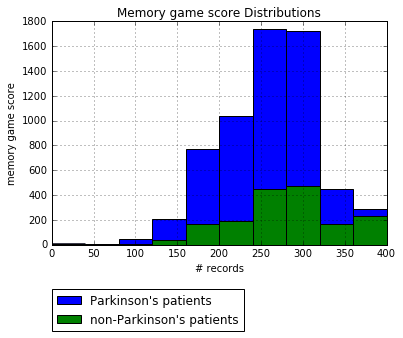

In [52]:
# plot the scores in Parkinsons and non-Parkinsons buckets
dPark.game_score.hist(label="Parkinson's patients")
dNon.game_score.hist(label="non-Parkinson's patients")
plt.title("Memory game score Distributions")
plt.ylabel('memory game score')
plt.xlabel('# records')
plt.legend(bbox_to_anchor=(0, -.2), loc=2, borderaxespad=0.)
pass

In [ ]:
# distribution of # records per Parkinson's and non-Parkinson's patient

In [ ]:
# look at, per patient, the records w/ different 'when took medicine' stats

In [36]:
# game_scores for Parkinson's vs non

for m in med_timepoint: 
    print m
    
doctor diagnosis & diagnosis year

for     diagYear   
    professionalDiagnosis
    
    
    

nan
I don't take Parkinson medications
Immediately before Parkinson medication
Another time
Just after Parkinson medication (at your best)


### Split into Parkinson's patients and non-patients

In [29]:
# the definitely parkinson's ones will have 
data.columns

memory[col_name] = data.events.apply(lambda e: event_kind in e)
   

Index([        u'recordId',       u'healthCode',        u'createdOn',
             u'appVersion',        u'phoneInfo',       u'game_score',
          u'game_numGames',    u'game_numFails',   u'game_startDate',
           u'game_endDate',     u'game_records',     u'medTimepoint',
       u'game_records_txt'],
      dtype='object')

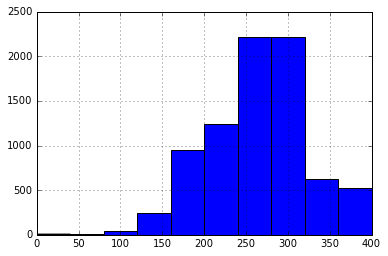

In [30]:
memory.game_score.hist()